Genetic Algorithms
----

Genetic Algorithms (GAs) are optimization inspired by the principles of natural selection and genetics, drawing inspiration from the "survival of the fittest". These algorithms are designed to mimic the process of natural selection to find approximate solutions to optimization and search problems. 

In a genetic algorithm, we generate several candidate solutions or chromosomes that form a 'population'. This population of solutions undergoes evolution using mutations and crossovers. Mutations are functions that introduce random changes to a chromosome (with some probability), and crossovers are functions that combine two solutions into a new, third 'offspring'. After the population undergoes mutation and produces an additional set of offspring solutions using crossovers, we retain some number of the best solutions from the total population. The process is repeated until the population converges. 

[Notes on Genetic Algorithms - Raj Venkat](https://venkat.prof/resources/AI/ch4#genetic_algo)

For a more detailed write-up on Genetic Algorithms, visit : https://natureofcode.com/genetic-algorithms/

In this section, we will try to solve linear regression using genetic algorithms.

A line in $n$ dimensions is represented by the equation: $y = c_0 + c_1 x_1 + c_2 x_2 + \dots + c_n x_n$

Here, $\{c_0, c_1, \dots, c_n\}$ are coefficients that we will try to optimize using genetic algorithms such that the line described by these coefficients best fits our data.

In [60]:
import numpy as np
import matplotlib.pyplot as plt

**Data Generation**: For this lab, we will first generate some random data that roughly fits a line in 2 dimensions. 

To do so, we first pick a line (such as $y=2x+4$). Now for a given set of values of $x$, \
we can first generate a corresponding value of the $y$ coordinate by simply using the equation of the line, $y=2x=4$. 

These pairs ($x,y$) would lie exactly on the line. However, for our data to be a bit more realistic,\
we want the data points to be slightly away from the line in either direction.

To achieve this, we can add a small random amount of noise $\epsilon$ to each $y$ coordinate,\
offsetting the placement of the point in 2-D space away from the line by $\epsilon$.\
Let us assume the noise lies in the range [$-5,5$]. Therefore, $\epsilon = \texttt{random}(-5,5)$ and $y=2x+4+\epsilon$.

In higher dimensions (e.g., for a plane in 3-D space $y=c_0 + c_1 x_1 + c_2 x_2$), for each point $\mathbf{x} = [1, x_1, x_2, \dots, x_n]^T$, given coefficients $\mathbf{c}=[c_0, c_1, c_2, \dots, c_n]$ we generate the corresponding points $\mathbf{y}=\mathbf{c}\cdot \mathbf{x} \pm \epsilon$.

In [61]:
def generate_data(coefficients):    
    # TODO: generate a numpy array X of 100 random points with dimension len(coefficients)
    # with each entry in the matrix X in the range [0,100]
    # Ensure the value in the first (dummy) dimension is always 1, to account for the bias term (c_0).
    X = np.random.rand(100, len(coefficients)) * 100
    X[:,0] = 1
    # For each point x in X, generate the corresponding value of y as y = c.x + epsilon
    # Make sure epsilon is different for every point x, and lies in the range [-5,5]
    # Use numpy operations instead of loops for efficiency
    epsilon = np.random.uniform(-5, 5, size=(100,))
    coefficients = np.array(coefficients)
    y = np.dot(X, coefficients) + epsilon
    return X, y, epsilon

Great! Now let's verify that your function behaves as expected, by generating some 2D data around the line $y=4+2x$, and visualizing it.\
Simply execute the cell below. You should expect to see data that *almost* lies along a straight line. 

(100, 2) (100,)


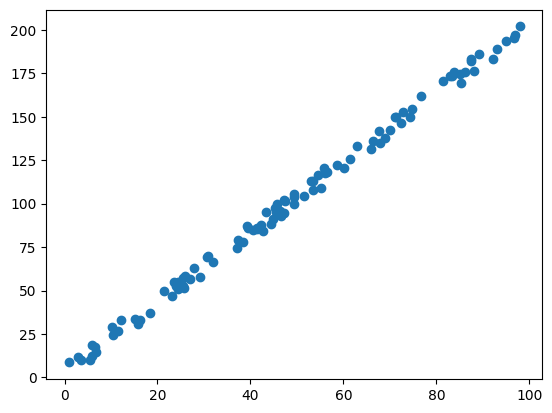

In [62]:
X_train, y_train, noise = generate_data([4,2])
print(X_train.shape, y_train.shape)
plt.scatter(X_train[:,1:], y_train) # Ignore dummy dimension while plotting

**Fitness Function**: We now define a function that will tell us how good a given solution is.
Recall that a solution in this setting is simply a set of coefficients,\
so a single solution may look like the vector \[4, 2\].
This particular solution, of course, is the optimal one, and what we hope our algorithm converges to.

Also, recall that a given set of coefficients defines a line (in 2 dimensions, a plane in 3 dimensions...).\
The fitness function simply evaluates how well this line fits our data.

For linear regression, we are interested in minimizing the distance between the line and all our data points.\
Define your fitness function below that leverages the **sum total** of the square of the vertical distances\
between the line and each data point. In other words, this is the residual sum of squared distances:
$\sum_{i=1}^n (y_i - c\cdot x_i)^2$

Since we are interested in minimizing the sum of squared distance, our *fitness* function should return the negative of the above quantity.

In [63]:
def fitness_function(coefficients, X, y):
    residual_sum_of_squares = np.sum((y - np.dot(X, coefficients))**2)
    return -residual_sum_of_squares  # returning the negative residual sum of squares

**Population Initialization**: In the cell below, complete the function to initialize your population of candidate solutions\
or chromosome $\mathbf{G} = \{\mathbf{g_1}, \mathbf{g_2}, \dots, \mathbf{g_n}\}$.
Each candidate is a vector with as many entries as the number of coefficients.\
Each entry should be an integer in the range \[-10,10\].

Define this as a numpy array to make operations easier and more efficient in later steps.

In [64]:
def initialize_population(pop_size, num_coefficients):
    population = np.random.uniform(-5, 5, size=(pop_size, num_coefficients))
    return population

**Natural Selection**: We define three functions below that together represent the 'natural selection' aspect of GAs. \
Note that this lab presents only one of several variants of GAs; several complex strategies exist for each of these functions.

1. Parent Selection - This function selects a subset of candidate solutions, that will then be combined to produce new offspring. <br /> This could be done using many strategies, but for simplicity, we assume that we pick the top 20% of solutions in terms of the fitness function.

2. Crossover - A crossover operator combines two parent solutions into one or more offspring solutions. <br /> In this lab, we simply average the two parents (element-wise) to produce a single offspring. <br />For instance, if the parent solutions are \[1,3,5\] and \[5,4,-8\] respectively, then the crossover yields \[(1+5)/2, (3+4)/2, (5-8)/2\] = \[3, 3.5, -1.5\].

3. Mutation - Finally, we make small changes to each new offspring solution with some small probability. <br />In this context, a change simply entails adding a small amount of noise to each dimension of each offspring chromosome<br /> (except the dummy dimension) with some probability $p$.

In [65]:
 # Function to select best fitted parents
def select_parents(population, fitness):
    selected_indices = np.argsort(-fitness)[:int(0.2*len(population)) if len(population)%2==0 else int(0.2*len(population))+1]
    return population[selected_indices]

# Function to perform crossover
def crossover(parents):
    return np.mean(parents, axis=0)

# Function to perform mutation in genetic algorithms
def mutate(individuals):
    mutation_rate = 0.2
    is_mutated = np.random.random((len(individuals), len(individuals[0]))) <= mutation_rate
    mutation = np.random.randint(-5, 5, (len(individuals), len(individuals[0])))
    return individuals + (is_mutated * mutation)

**TODO**

Do you think these are the best possible variants of these operations for our task? Can you think of other implementations of the parent selection, crossover and mutation operators?

Alternative implementations for each operation-

1. Parent Selection: Instead of selecting a fixed percentage of top 20% of solutions, we could use rank based selections and assign probabilities based on the rank of each individual's fitness relative to the rest of the population.
2. Crossover: Instead of a simple average crossover, we can have a uniform crossover by randomly selecting genes from either parent with equal probability.
3. Mutation: Mutation rates can also be dynamically adjusted based on the performance of the population or the convergence of the algorithm.


In [66]:
# This function specifies a stop criteria, where we check the fitness function of the best chromosome from the pool.
# Recall that the Residual Sum of Squares Error is minimized when the error is 0 (perfect fit), therefore the fitness
# function (negative of RSS Error) has an upper bound of 0. The closer we are to 0, the better the fit. Here, we consider that an error of 
# greater than -3 is a good enough fit. Feel free to tweak this value and observe the effects.
def meets_stop_criteria(best_error):
    if best_error > -3:
        return True
    return False

**Control Flow**: We now define the central logic of how our GA works. We initialize the population size and specify a number of generations for the algorithm to run. These values default to 10 and 20 respectively.

Once we initialize a population, we compute every individual's fitness score and select the top 20% for crossover. From our list of parent chromosomes, we pick pairs at random without replacement and combine them using crossover (if we start with 10 parents, we get 5 offspring in this implementation). 

Each offspring chromosome is then mutated using the function we defined earlier. Finally, the generated offspring replace the same number of lowest-scoring individuals in the original population (i.e., if we have 5 offspring, then we replace the 5 lowest scoring individuals).

In [67]:
def genetic_algorithm(X, y, pop_size=10, num_generations=20):
    num_coefficients = len(X[0])
    population = initialize_population(pop_size, num_coefficients)
    for generation in range(num_generations):
        fitness = np.array([fitness_function(chromosome, X, y) for chromosome in population])
        
        print("Fitness Scores: ", fitness)
        parents = select_parents(population, fitness)
        print("Selected Parents: ", parents)

        # Apply crossover to create new individuals by randomly pairing selected parents without replacement
        # HINT: One possible implementation might combine np.random.shuffle, np.stack and list comprehension
        offspring = np.array([crossover(parents[i:i+2]) for i in range(0, len(parents), 2)])
        
        print("Offspring from Crossover: ", offspring)

        # Apply mutations to each offspring individual
        offspring = mutate(offspring)
        
        print("Offspring after Mutations: ", offspring)

        # Update population by replacing the k weakest chromosomes with the k generated offspring for the next generation
        population[np.argsort(fitness)[:len(offspring)]] = offspring
        
        print("Updated Population: ", population)
        
        best_individual = population[np.argmax(fitness)]
        best_error = fitness_function(best_individual, X, y)
        print("Generation", generation, "Best Error:", best_error)
        if meets_stop_criteria(best_error):
            break
    return best_individual

In [68]:
# Executes the genetic algorithm
def run_genetic_algorithm(num_cofficients,population_size,num_generations):
    X, y, epsilon = generate_data(num_cofficients)
    
    # Run genetic algorithm for linear regression
    best_coefficients = genetic_algorithm(X, y,population_size,num_generations)
    print("Best coefficients are:", best_coefficients)

In [69]:
# Feel free to experiment with these values
cofficients = [4,3,2,1,4]
population_size = 100
num_generations = 500

run_genetic_algorithm(cofficients, population_size, num_generations)

Fitness Scores:  [-3.10012210e+07 -9.91235145e+07 -2.90521541e+07 -3.43094556e+07
 -1.06624369e+07 -1.53942070e+07 -2.31495189e+07 -1.14661020e+08
 -8.66702774e+07 -4.78162755e+06 -1.15358604e+07 -4.19580058e+07
 -5.87256928e+07 -1.08097882e+07 -2.60736390e+06 -8.27867723e+07
 -2.32234371e+07 -1.30434927e+07 -2.47824981e+07 -1.03436006e+07
 -6.28546283e+07 -4.60921770e+07 -4.33804270e+07 -1.07144486e+07
 -5.61676317e+07 -1.48084110e+08 -1.68901237e+07 -1.34920634e+07
 -7.43743525e+07 -2.13105921e+07 -4.36702217e+06 -2.83116300e+06
 -3.91377695e+06 -1.40853789e+07 -1.05724417e+07 -1.79655359e+07
 -5.29834497e+06 -7.10318792e+07 -8.26800617e+06 -6.25280143e+07
 -1.46271156e+07 -5.49208770e+07 -4.38744291e+07 -3.59849166e+07
 -5.97059501e+07 -2.40870606e+06 -3.47864546e+07 -4.67137460e+07
 -3.20303192e+06 -1.15291767e+07 -8.07033772e+07 -8.98746128e+07
 -1.15948408e+08 -4.59348229e+07 -1.21935451e+07 -6.46826100e+05
 -3.54140285e+06 -4.63321336e+07 -1.36267811e+07 -2.34252824e+06
 -6.1469

Fitness Scores:  [  -224426.67997302   -226608.84894409   -231962.05269424
   -188828.37079339   -224426.67997302   -379589.51649982
  -1742304.83181488   -214742.75219981   -220916.78914242
  -8131005.0174352    -225772.10410903   -225906.91718047
   -203509.7031387    -189108.81109797   -194562.83486518
   -295029.55599941   -191331.44828388   -379589.51649982
 -14169617.8775819    -188961.75398182   -224838.95625204
   -185066.66735337   -296377.79507814   -226608.84894409
   -277623.98806956   -226608.84894409   -214141.39683411
   -242104.8654512    -194094.08082822   -224731.06317343
   -225007.42306519   -216707.04981966   -261637.89448766
   -223320.17274754   -257780.92806762   -257780.92806762
   -224698.61443889   -222700.64775945   -339016.72174728
   -183848.26429461   -188602.62619968   -213895.92474431
   -223109.96613925   -215087.12941288   -221748.9480426
   -224765.26972047   -324207.71464465   -185872.32529928
   -289569.32307307   -324207.71464465   -226608.8489440

#TODO:
How efficient do you think genetic algorithm defined was in getting the correct coefficients to solve the linear equations? What other tasks do you think genetic algorithms can solve?

For linear regression, especially in higher dimensions, this fitness function can lead to good solutions, especially if the data follows a linear pattern closely. However, in cases where the relationship between the variables is more complex or nonlinear, this fitness function might struggle to find optimal solutions.
The genetic algorithm in this implementation involves creating populations, evaluating fitness, selecting parents, performing crossover and mutation, and repeating this process for multiple generations. Each of these steps can be time-consuming, especially for large populations and high-dimensional problems. Additionally, the effectiveness of a genetic algorithm heavily relies on parameter tuning, such as population size, mutation rate, and crossover strategy.

Some other tasks that Genetic Algorithms can solve are-
1. Routing and scheduling: Finding optimal routes or schedules in transportation and logistics.
2. Resource allocation: Optimizing resource allocation in various domains such as finance, manufacturing, and telecommunications.